##Problem Set 3

Olivia Natan



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mpl
import seaborn as sns
import scipy.stats as sts

%matplotlib inline

:0: FutureWarning: IPython widgets are experimental and may change in the future.


MLE estimation of a simple macroeconomic model

We observe 100 quarters of time series data on the following variables: $(c_t, k_t, w_t, r_t)$, which are aggregate consumption, last period's household savings, wage per unit labor, and the interest rate (return on investment), respectively. Aggregate productivity is $z_t$, which follows an AR(1) process as shown below.

We assume the following model: $$ (c_t)^{-1} - \beta E[r_{t+1} c_{t+1}^{-1}]=0$$
$$c_t + k_{t+1} − w_t − r_t k_t = 0 $$
$$w_t - (1-\alpha)exp(z_t) k_t^{\alpha}=0$$
$$r_t - \alpha exp(z_t) k_t^{\alpha-1}=0$$
$$z_t = \rho z_{t-1} + (1-\rho) \mu + \epsilon_t$$
$$where \;\; \epsilon_t \sim N(0, \sigma^2)$$


We want to estimate $(\alpha, \beta, \rho, \mu, \sigma)$ where   $\alpha ,\beta \in (0,1)$, $\mu, \sigma >0$ and $\rho \in (-1, 1)$.

In [2]:
# read in data
df = pd.read_csv('MacroSeries.txt',sep=',',header=None,names=['ct','kt','wt','rt'])
df['tt'] = df.index+1
df.head()

,ct,kt,wt,rt,tt
0,10671094.090618,8040697.000000,10594376.194040,0.954120,1
1,11694867.840305,7595071.761176,11610789.707937,1.107009,2
2,9292394.242982,8323735.104414,9225588.259037,0.802596,3
3,7913164.544811,6613792.410530,7856274.282763,0.860176,4
4,8140994.183307,5632135.942712,8082465.981373,1.039183,5


We start by assuming the following: $$ \beta = 0.99$$ $$z_0 = \mu \implies z_1=\mu + \epsilon_1$$

##(a)
We want to estimate the vector of parameters $(\alpha, \rho, \mu, \sigma)$ using the data from 2 variables: $w_t$ and $k_t$. 

Recall we can fully pin down the likelihood from the data using the following 2 equations form above:
$$w_t - (1-\alpha)exp(z_t) k_t^{\alpha}=0$$
$$z_t = \rho z_{t-1} + (1-\rho) \mu + \epsilon_t$$
$$where \;\; \epsilon_t \sim N(0, \sigma^2)$$

In particular, note that $$z_t - \rho z_{t-1} - (1-\rho) \mu \sim N(0,\sigma^2)$$

Take for example, the likelihood of the first period of data, where we know $z_1 = z_0 + \epsilon_1$. In particular, then, $z_1 \sim N(\mu, \sigma^2)$. 

We can then transform our model equation: $$ log\left(\frac{w_t}{(1-\alpha) k_t^{\alpha}}\right) = z_t$$

Thus our log-likelihood for the first period is: $$\mathcal{L}(\alpha,\rho,\mu,\sigma|w_1,k_1) = \phi\left(\frac{log\left(\frac{w_1}{(1-\alpha) k_1^{\alpha}}\right) -\mu}{\sigma}\right)$$

Where $\phi()$ is the standard normal pdf. 

For subsequent periods, note that $z_t | z_{t-1}, \rho,\mu,\sigma \sim N(\rho z_{t-1} + (1-\rho) \mu, \sigma^2)$, so we have $$\mathcal{L}(\alpha,\rho,\mu,\sigma|w_t,k_t,z_{t-1}) = \phi\left(\frac{log\left(\frac{w_t}{(1-\alpha) k_t^{\alpha}}\right) -\rho z_{t-1} - (1-\rho) \mu}{\sigma}\right) $$

In [3]:
# want to use built in pdf

import scipy.stats as sts
import numpy as np 

def crit_norm(params,*args):
    #alpha_0, rho_0, mu_0, sigma_0 = params
    #alpha = np.exp(alpha_0)/(1+ np.exp(alpha_0)) # keep in (0,1)
    #rho = 2*(np.exp(rho_0)/(1+np.exp(rho_0))) - 1 #keep in (-1,1)
    #mu = np.exp(mu_0)
    #sigma = np.exp(sigma_0)
    alpha, rho, mu, sigma = params
    kvals = np.array(args[0])
    wvals = np.array(args[1])
    zvals = np.array(np.log(wvals/((1-alpha)*(kvals**alpha))))
    lag_zvals = np.roll(zvals,1)
    lag_zvals[0] = mu
    mus = rho*lag_zvals + (1-rho)*mu
    xvals = zvals-mus
    log_lik_val = sts.norm.logpdf(xvals,loc=0,scale=sigma).sum()
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [7]:
crit_norm([0.5,0.5,10,1],df['kt'] ,df['wt'])

107.05487636032119

In [8]:
import scipy.optimize as opt
params_init = np.array([0.5,0.5,10,2])
mle1_args = (df['kt'] ,df['wt'])
bounds1 = ((1e-8,1-1e-8),(-1+1e-8,1-1e-8),(0,None),(0,None))
results = opt.minimize(crit_norm, params_init, args=(mle1_args),method='L-BFGS-B',tol=1e-12,bounds=bounds1,options={'maxiter':1000})
alphaMLE1,rhoMLE1,muMLE1,sigmaMLE1 = results.x

In [9]:
results

  status: 0
 success: True
    nfev: 140
     fun: 88.879758042295094
       x: array([ 0.51320736,  0.86592634,  5.37711278,  0.48223028])
 message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     jac: array([-555.11958976, -648.92976894,  -40.31299028,  -82.613046  ])
     nit: 3

In [10]:
results.x

array([ 0.51320736,  0.86592634,  5.37711278,  0.48223028])

## part (b)

We will not use other set of data and model equations to estimate the four parameters - $(r_t, k_t)$. 

Recall we can rearrange $$r_t - \alpha exp(z_t) k_t^{\alpha-1}=0$$
$$z_t = \rho z_{t-1} + (1-\rho) \mu + \epsilon_t$$
$$where \;\; \epsilon_t \sim N(0, \sigma^2)$$

and get 
$$log\left(\frac{r_t}{\alpha k_t^{\alpha-1}}\right) = z_t$$

Then our likelihood for each time period is:
$$\mathcal{L}(\alpha,\rho,\mu,\sigma|r_t,k_t,z_{t-1}) = \phi\left(\frac{log\left(\frac{r_t}{\alpha k_t^{\alpha-1}}\right) -\rho z_{t-1} - (1-\rho) \mu}{\sigma}\right) $$

Where $\phi()$ is the standard normal PDF. We again sequentially condition and use $\mu$ as the value of $z_0$. 



In [11]:
def crit_norm2(params,*args):
    alpha, rho, mu, sigma = params
    kvals = np.array(args[0])
    rvals = np.array(args[1])
    zvals = np.array(np.log(rvals/(alpha*(kvals**(alpha-1)))))
    lag_zvals = np.roll(zvals,1)
    lag_zvals[0] = mu
    mus = rho*lag_zvals + (1-rho)*mu
    xvals = zvals-mus
    log_lik_val = sts.norm.logpdf(xvals,loc=0,scale=sigma).sum()
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [12]:
import scipy.optimize as opt
params_init2 = np.array([0.1,0.9,10,1])
mle2_args = (df['kt'] ,df['rt'])
bounds2 = ((1e-8,1-1e-8),(-1+1e-8,1-1e-8),(0,None),(0,None))
results2 = opt.minimize(crit_norm2, params_init2, args=(mle2_args),method='L-BFGS-B',tol=1e-12,bounds=bounds2,options={'maxiter':1000})
alphaMLE2,rhoMLE2,muMLE2,sigmaMLE2 = results2.x

In [13]:
results2

  status: 0
 success: True
    nfev: 465
     fun: -96.706908041157121
       x: array([ 0.45749022,  0.72050916,  9.37076158,  0.09199629])
 message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     jac: array([-0.00339639,  0.00019895, -0.00019043,  0.00138982])
     nit: 47

## Part (c)
We take our results from the first MLE results, and we want to compute the probability that the interest rate is greater than 1 given $k_t = 7,500,000$ and $z_{t-1} = 10$. 

First, consider that $$ r_t = \alpha exp(z_t) k_t^{\alpha-1}$$

Thus the distribution of $r_t | \alpha,\rho, \mu, \sigma, z_{t-1}, k_t$ is fully specified and lognormal. Given parameter estimates and $z_{t-1}$, $$z_t|z_{t-1},\hat\rho,\hat\mu,\hat\sigma \sim N(\hat\rho z_{t-1} + (1-\hat\rho) \hat\mu, \hat\sigma^2)$$


This implies that $exp(z_t)|z_{t-1},\hat\rho,\hat\mu,\hat\sigma \sim logN(\hat\rho z_{t-1} + (1-\hat\rho) \hat\mu, \hat\sigma^2)$


Then $r_t$ is distributed as a transformation of a lognormal, and $log(r_t) = log(\alpha)+ z_t + (\alpha-1)log(k_t)$. In particular, we can then write: 

$$ log(r_t)|\hat\alpha, \hat\rho,\hat\mu,\hat\sigma,z_{t-1},k_t \sim N(log(\hat\alpha) + (\hat\alpha-1)log(k_t) +\hat\rho z_{t-1} + (1-\hat\rho) \hat\mu, \hat\sigma^2)$$

Remember we are trying to figure out $Pr(r_t>1|...)$ - if we take logs, this is the same as $Pr(log(r_t)>0|...)$ and we can use the normal cdf.

In [14]:
mean_hat = np.log(alphaMLE1) + (alphaMLE1-1)*np.log(7500000) + rhoMLE1*10 + (1-rhoMLE1)*muMLE1
prob_rt_over_1 = 1-sts.norm.cdf(0,loc=mean_hat,scale=sigmaMLE1)
prob_rt_over_1

0.98160965491220697

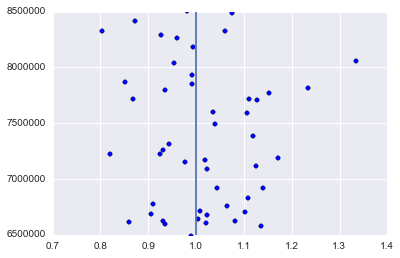

In [28]:
mpl.scatter(df['rt'],df['kt'])
mpl.ylim(6500000, 8500000)
mpl.plot((1,1), (6500000, 8500000))

In [30]:
df.loc[(df['kt']>7000000)&(df['kt']<8000000)]['rt'].describe()

count    22.000000
mean      1.022400
std       0.111248
min       0.819379
25%       0.937132
50%       1.020793
75%       1.117244
max       1.233322
Name: rt, dtype: float64